# Anomaly Detection

Anomaly detection on public spending recovered from Portal da Transparência.

<img src="img/anomalies_detected.jpg" align="center">

### Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import scipy as sc
import yaml
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest

# %matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Lendo as configurações
with open('.\configurations.yml') as file:
    configurations = yaml.load(file, Loader=yaml.FullLoader)

### Exploratory Data Analysis (EDA)

In [3]:
db = sqlite3.connect(configurations["Database"]["Path"]) # connecting to sqlite database

In [4]:
df = pd.read_sql_query("SELECT * FROM CARTOES", db)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62685 entries, 0 to 62684
Data columns (total 54 columns):
id                                 62685 non-null int64
mesExtrato                         62685 non-null object
dataTransacao                      62685 non-null object
valorTransacao                     62685 non-null float64
id_tipoCartao                      62685 non-null int64
codigo_tipoCartao                  62685 non-null object
descricao_tipoCartao               62685 non-null object
numeroInscricaoSocial              62685 non-null object
nome_estabelecimento               62685 non-null object
razaoSocialReceita                 62685 non-null object
nomeFantasiaReceita                62685 non-null object
localidadePessoa                   62685 non-null object
dataAbertura                       62685 non-null object
enderecoEletronico                 62685 non-null object
numeroTelefone                     62685 non-null object
descricaoLogradouro                62

In [6]:
df.head()

,id,mesExtrato,dataTransacao,valorTransacao,id_tipoCartao,codigo_tipoCartao,descricao_tipoCartao,numeroInscricaoSocial,nome_estabelecimento,razaoSocialReceita,...,nome_orgaoVinculado,codigoSIAFI,cnpj,sigla_orgaoVinculado,descricaoPoder,codigo_orgaoMaximo,sigla_orgaoMaximo,nome_orgaoMaximo,codigoFormatado_portador,nome_portador
0,151041007,10/2019,18/09/2019,9.00,1,1,Cartão de Pagamento do Governo Federal - CPGF,,ZOOP TECNOLOGIA E MEIOS DE PAGAMENTO S.A.,ZOOP TECNOLOGIA E MEIOS DE PAGAMENTO S.A.,...,Instituto Federal Catarinense,26422,10635424000186,IFC,EXECUTIVO,26000,MEC,Ministério da Educação,***.857.959-**,HORALDO ANTONIO BRANDALISE
1,151041008,09/2019,02/08/2019,20.00,1,1,Cartão de Pagamento do Governo Federal - CPGF,-1,SEM INFORMACAO,Sem informação,...,Ministério da Economia - Unidades com vínculo ...,25000,00394460000141,ME,EXECUTIVO,25000,ME,Ministério da Economia,***.646.795-**,JOAO VICTOR BARBOSA DE MATOS
2,151041009,04/2019,19/03/2019,609.38,1,1,Cartão de Pagamento do Governo Federal - CPGF,,M. L. COMERCIO E INDUSTRIA DE ALUMINIO LTDA,M. L. COMERCIO E INDUSTRIA DE ALUMINIO LTDA,...,Universidade Federal da Bahia,26232,15180714000104,UFBA,EXECUTIVO,26000,MEC,Ministério da Educação,***.483.205-**,ANTONIO CARLOS SAMPAIO AMARAL
3,151041010,08/2019,09/07/2019,389.60,1,1,Cartão de Pagamento do Governo Federal - CPGF,-1,SEM INFORMACAO,Sem informação,...,Hospital de Clínicas de Porto Alegre,26294,87020517000120,HCPA,EXECUTIVO,26000,MEC,Ministério da Educação,***.877.890-**,ALROUCIAN SANTOS DA MOTTA
4,151041011,04/2019,13/03/2019,14.99,1,1,Cartão de Pagamento do Governo Federal - CPGF,,ATACADO DA CONSTRUCAO LTDA,ATACADO DA CONSTRUCAO LTDA,...,Advocacia-Geral da União - Unidades com víncul...,63000,26994558000123,AGU,EXECUTIVO,63000,AGU,Advocacia-Geral da União,***.449.134-**,SENISE LIRA MONTENEGRO


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,62685.0,1.524251e+08,988691.686784,151041007.0,151593567.0,152094122.0,1.532000e+08,154293416.0
valorTransacao,62685.0,5.302797e+02,2346.239759,-27000.0,123.0,343.0,6.940300e+02,342000.0
id_tipoCartao,62685.0,1.465550e+00,0.537931,1.0,1.0,1.0,2.000000e+00,3.0


In [ ]:
df.plot.scatter("id", "valorTransacao", alpha=0.5)

In [ ]:
df[df.valorTransacao < 50000].plot.scatter("id", "valorTransacao", alpha=0.5)

In [ ]:
df.valorTransacao.hist(range=(0, 10000), bins=50)

In [ ]:
df.valorTransacao.sort_values()

In [ ]:
df.valorTransacao.sort_values(ascending=False)

In [ ]:
len(df[df.valorTransacao <= 0])

### Feature Engeneering

- Número de Gastos no (Último mês/Semestre/...)
- Quantidade de Gastos com valores iguais (Último mês/Semestre...)
- Transações de mesma categoria no mesmo dia (Capturando similaridades)
- Horários próximos de transações similares

### Anomaly Detection

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2] # concatenate arrays quickly
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations",
            "new abnormal observations"],
           loc="upper left")
plt.show()

In [ ]:
# 3D Isolation Forest Test
model = IsolationForest()

X = rng.randn(100, 3) # random creation of 3D array with normal distribution
X_train = np.r_[X + 2, X - 2]
X_hzrd = rng.uniform(low=-5, high=4, size=(20, 2))

model.fit(X_train)
y_pred_train = model.predict(X_train)
y_pred_train

In [ ]:
fig = plt.figure(1, figsize=(12, 10))
ax = Axes3D(fig, elev=-150, azim=110)

z = []

def nparrays(x):
    for i in x:
        if i == 1:
            z.append('white')
        else:
            z.append('red')
            
nparrays(y_pred_train)

z = np.array(z)
z.ravel()         
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=z, cmap=plt.cm.rainbow)

In [ ]:
y_pred_train = clf.predict(X_hzrd)

In [ ]:
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ['a', 'b', 'c'],
                class_names = ['normal', 'anomaly'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

In [ ]:
!dot -Tpdf tree.dot -o tree.pdf

___

In [3]:
with open('.\configurations.yml') as file:
    configurations = yaml.load(file, Loader=yaml.FullLoader)

db = sqlite3.connect(configurations["Database"]["Path"]) # connecting to sqlite database

df = pd.read_sql_query('''SELECT 
  id,
  valorTransacao,
  dataTransacao,
  codigoSubclasse,
  tipoCodigo,
  ROW_NUMBER() OVER(PARTITION BY valorTransacao, nome_portador ORDER BY dataTransacao ASC) 								AS valorTransacao_count_byPerson,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, nome_portador ORDER BY dataTransacao ASC) 			AS codigoFormatado_estabelecimento_count_byPerson,
  ROW_NUMBER() OVER(PARTITION BY valorTransacao, codigo_unidadeGestora ORDER BY dataTransacao ASC) 						AS valorTransacao_count_byAgency,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, codigo_unidadeGestora ORDER BY dataTransacao ASC) 	AS codigoFormatado_estabelecimento_count_byAgency,
  ROW_NUMBER() OVER(PARTITION BY valorTransacao, nome_orgaoMaximo ORDER BY dataTransacao ASC) 							AS valorTransacao_count_byDepartment,
  ROW_NUMBER() OVER(PARTITION BY codigoFormatado_estabelecimento, nome_orgaoMaximo ORDER BY dataTransacao ASC) 			AS codigoFormatado_estabelecimento_count_bydepartment  
FROM cartoes 
WHERE valorTransacao||nome_estabelecimento||nome_portador not in (SELECT -valorTransacao||nome_estabelecimento||nome_portador from cartoes where valorTransacao <0)
and valorTransacao > 0''', db)

In [4]:
df['dataTransacao'] = pd.to_datetime(df['dataTransacao'])
df['diaSemana'] = df['dataTransacao'].dt.dayofweek
df['dia'] = df['dataTransacao'].dt.day
df['mes'] = df['dataTransacao'].dt.month
df['ano'] = df['dataTransacao'].dt.year

In [5]:
df.codigoSubclasse = df.codigoSubclasse.map(int)

In [6]:
df.tipoCodigo = df.tipoCodigo.apply(lambda x: 1 if x=='CNPJ' else 0)
model = IsolationForest(random_state=42)
df['result'] = model.fit_predict(df.drop(labels=['id','dataTransacao'],axis=1))
df['score'] = -model.score_samples(df.drop(labels=['id','dataTransacao','result'],axis=1))

In [7]:
df.result.value_counts(normalize=True)

 1    0.873001
-1    0.126999
Name: result, dtype: float64

In [12]:
df[['id','score','result']].to_sql(name='results', con=db, if_exists='replace', index=False)

In [13]:
df.sort_values(by="score", ascending=False).head()

,id,valorTransacao,dataTransacao,codigoSubclasse,tipoCodigo,valorTransacao_count_byPerson,codigoFormatado_estabelecimento_count_byPerson,valorTransacao_count_byAgency,codigoFormatado_estabelecimento_count_byAgency,valorTransacao_count_byDepartment,codigoFormatado_estabelecimento_count_bydepartment,diaSemana,dia,mes,ano,result,score
55872,151747640,1000.0,2019-12-23,0,0,734,3,736,3,736,3,0,23,12,2019,-1,0.726144
55944,151148866,1000.0,2019-01-30,0,0,806,2,808,2,809,2,2,30,1,2019,-1,0.726128
55943,152047889,1000.0,2019-01-30,0,0,805,2,807,2,808,2,2,30,1,2019,-1,0.726128
55940,151352379,1000.0,2019-01-30,0,0,802,2,804,2,805,2,2,30,1,2019,-1,0.726128
55941,151051575,1000.0,2019-01-30,0,0,803,2,805,2,806,2,2,30,1,2019,-1,0.726128


In [14]:
#!pip3 install shap

In [15]:
import shap
shap.initjs() # Need to load JS vis in the notebook

In [16]:
explainer = shap.TreeExplainer(model) # settings model
observations = df.drop(columns=['id', 'dataTransacao', 'result', 'score']).sample(1000).to_numpy() # setting dataframe sample
all_features = list(df.drop(columns=['id', 'dataTransacao', 'result', 'score']).columns) # setting columns names
shap_values = explainer.shap_values(observations) # In order to compute the shapley values with the tree explainer, we need to call the shap_values methods passing a dataset.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [17]:
all_features

['valorTransacao',
 'codigoSubclasse',
 'tipoCodigo',
 'valorTransacao_count_byPerson',
 'codigoFormatado_estabelecimento_count_byPerson',
 'valorTransacao_count_byAgency',
 'codigoFormatado_estabelecimento_count_byAgency',
 'valorTransacao_count_byDepartment',
 'codigoFormatado_estabelecimento_count_bydepartment',
 'diaSemana',
 'dia',
 'mes',
 'ano']

In [18]:
all_features = ['valTrans', 'codSubclasse', 'tipoCod', 'valRepetidoPessoa', 'codEstabPessoa', 'valTransAg', 'codEstabAg', 'valTransDept', 'codEstabDept', 'DOW', 'dia', 'mes', 'ano']

In [36]:
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features)

In [29]:
plt = shap.force_plot(explainer.expected_value, shap_values,
                features=observations, feature_names=all_features)

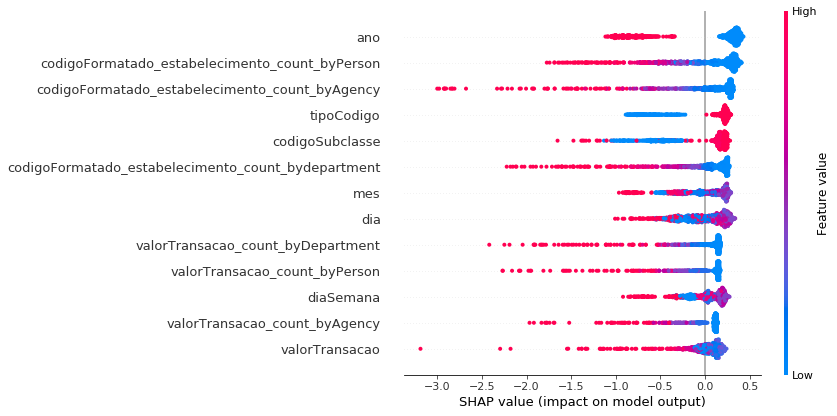

In [30]:
shap.summary_plot(shap_values, features=observations, feature_names=all_features)

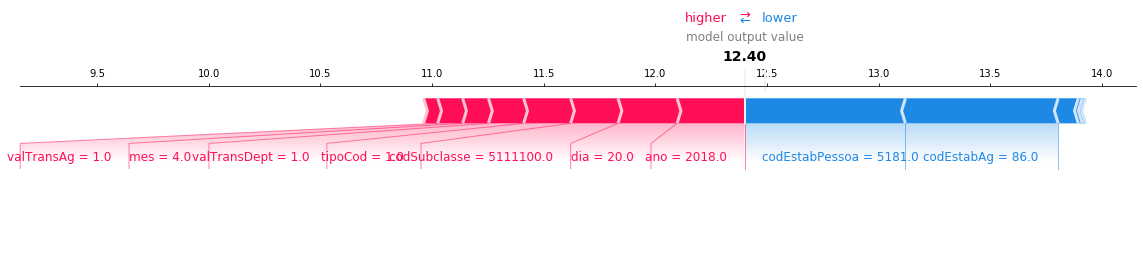

In [42]:
# SAVE SHAP PLOT .PNG
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features, show=False, matplotlib=True).savefig('explainer.png')

In [41]:
# SAVE PLOT AS HTML

shap.save_html('explainer.html',shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features))

In [19]:
#EXPORT TREE IMAGE

estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = all_features,
                class_names = ['normal', 'anomaly'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

0

In [20]:
!dot -Tpdf tree.dot -o tree.pdf